# Deep Learning in Computer vision

# tasks
1. LeNet
2. Validation
3. Validation loss
4. Epoch acc.
5. Loss curve
6. Normalization
7. Errors (why?)

# convolution and correlation

In [52]:
import cv2
from scipy.signal import correlate2d, convolve2d

import numpy as np

from IPython.display import clear_output

import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from IPython.display import clear_output

from collections import defaultdict

import seaborn as sn
import pandas as pd

In [2]:
arr = [1,4, 3,4 ,5 ,6]
a = np.median(arr)

In [3]:
a.dtype

dtype('float64')

In [4]:
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('class probability')
    ax2.set_xlabel('probability')
    ax2.set_ylabel('class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [5]:
def show_features(features):
    if len(features.shape) < 4:
        batch, num_feature = features.shape[:2]
        for i, feature in enumerate(features):
            plt.subplot(1, num_feature, i+1)
            plt.imshow(feature.numpy().transpose(1,2,0))
    else:
        batch, num_feature = features.shape[:2]
        for i, element in enumerate(features):
            for j, feature in enumerate(element):
                plt.subplot(batch, num_feature, i * num_feature + j + 1)
                plt.imshow(feature.numpy())

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
T = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [8]:
num, height, width = np.array(train_data.data).shape
img_min = np.array(train_data.data).min()
img_max = np.array(train_data.data).max()
img_norm_mean = np.array(train_data.data, dtype=float).mean() / img_max
img_std = np.sqrt(np.sum((np.array(train_data.data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
print(img_min, img_max, img_norm_mean, img_std)

0 255 0.1306604762738429 0.3081078038564622


In [9]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((img_norm_mean,), (img_std,)) # normalize inputs
])

train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [53]:
print('train set shape: ', train_data.data.shape)
print('train labels shape: ', train_data.targets.shape)

train set shape:  torch.Size([60000, 28, 28])
train labels shape:  torch.Size([60000])


In [54]:
print('test set shape: ', test_data.data.shape)
print('test labels shape: ', test_data.targets.shape)

test set shape:  torch.Size([10000, 28, 28])
test labels shape:  torch.Size([10000])


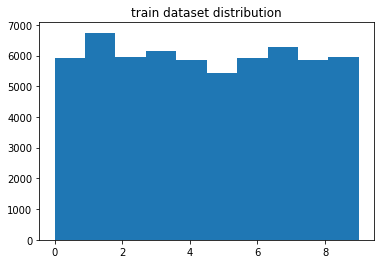

In [55]:
plt.title('train dataset distribution')
plt.hist(train_data.targets);

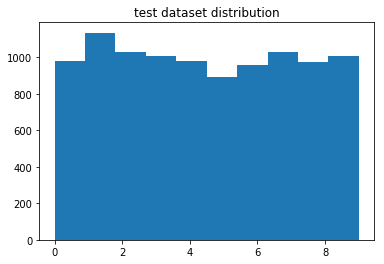

In [56]:
plt.title('test dataset distribution')
plt.hist(test_data.targets);

In [14]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=8, 
                                          shuffle=False)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

tensor([4, 1, 1, 2, 6, 6, 6, 7])


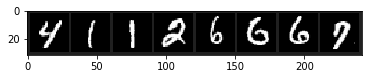

In [15]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images)[0,:,:], cmap='gray')
print(labels)

# LeNet

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=4, 
                               kernel_size=5, 
                               padding=0)
        self.conv2 = nn.Conv2d(in_channels=4, 
                               out_channels=8, 
                               kernel_size=3, 
                               padding=0)
        self.fc1 = nn.Linear(8 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1, 8 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
#         x = F.max_pool2d(F.relu(self.conv1(x)),2)
#         x = F.max_pool2d(F.relu(self.conv2(x)),2)
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
#         x = F.max_pool2d(F.relu(self.conv1(x)),2)
        return x

In [18]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

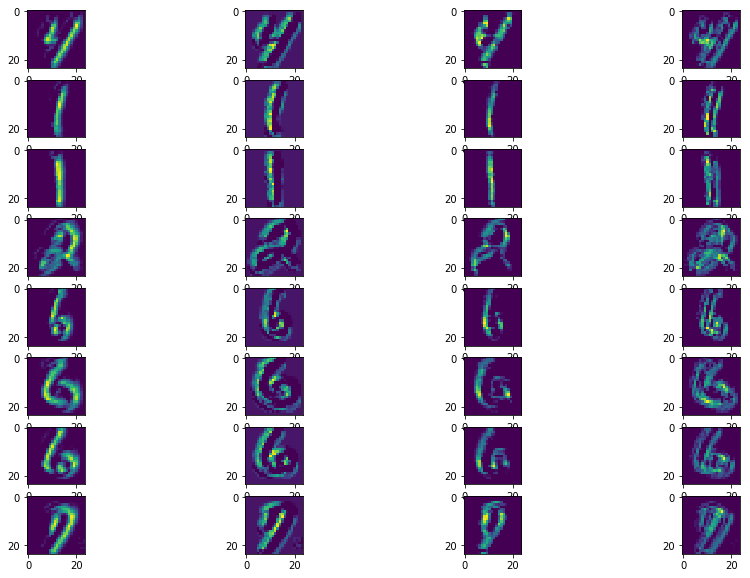

In [19]:
plt.figure(figsize=(15,10))
show_features(net.features_1(images.to(device)).detach().cpu())

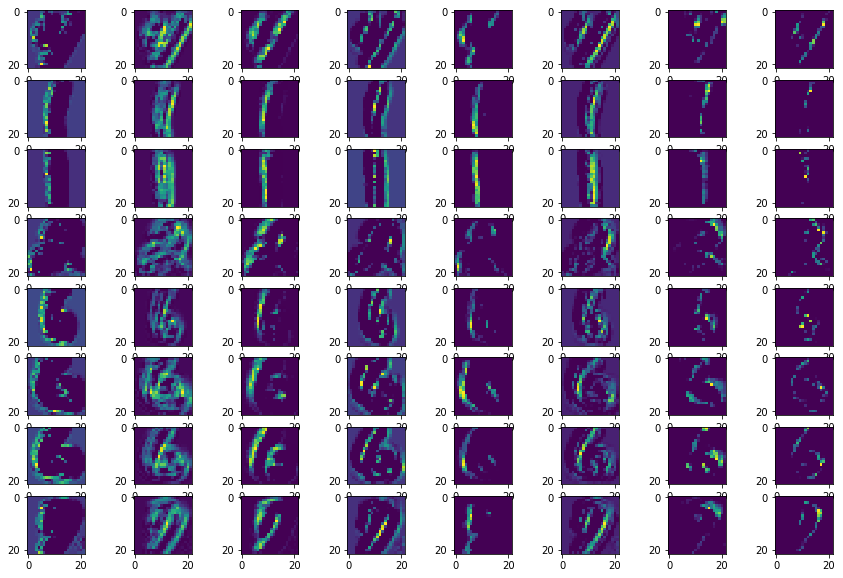

In [20]:
plt.figure(figsize=(15,10))
show_features(net.features_2(images.to(device)).detach().cpu())

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

epoch=0

curve_x=[]
loss_curve_y=[]
v_loss_curve_y=[]
acc_curve_y=[]

In [22]:
num_epochs=50

e=0
while e < num_epochs:
    epoch+=1
    e+=1

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 1000 == 999:    
            validation_loss = 0.
            correct = 0
            total = 0

            with torch.no_grad():
                net.eval()

                for v_data in test_loader:
                    v_inputs, v_labels = v_data[0].to(device), v_data[1].to(device)

                    v_outputs = net(v_inputs)
                    v_loss = criterion(v_outputs, v_labels)

                    validation_loss+=v_loss.item()

                    _, predicted = torch.max(v_outputs.data, 1)
                    total += v_labels.size(0)
                    correct += (predicted == v_labels).sum().item()
            net.train()
        #     clear_output()              
            print('epoch %d, step %5d training loss: %.3f validation loss: %.3f test acc: %.3f' %
              (epoch, i + 1, running_loss / 1000, validation_loss/1000, 100 * correct / total))
            
            curve_x.append(len(curve_x))
            loss_curve_y.append(running_loss/1000)
            v_loss_curve_y.append(validation_loss/1000)
            acc_curve_y.append(100 * correct / total)
            
            running_loss = 0.0

print('finish')

epoch 1, step  1000 training loss: 2.302 validation loss: 2.872 test acc: 10.280
epoch 1, step  2000 training loss: 2.292 validation loss: 2.859 test acc: 10.280
epoch 1, step  3000 training loss: 2.279 validation loss: 2.833 test acc: 23.180
epoch 1, step  4000 training loss: 2.241 validation loss: 2.753 test acc: 48.520
epoch 1, step  5000 training loss: 2.067 validation loss: 2.222 test acc: 55.530
epoch 1, step  6000 training loss: 1.234 validation loss: 0.909 test acc: 78.750
epoch 1, step  7000 training loss: 0.617 validation loss: 0.646 test acc: 82.070
epoch 2, step  1000 training loss: 0.425 validation loss: 0.479 test acc: 88.330
epoch 2, step  2000 training loss: 0.387 validation loss: 0.433 test acc: 89.040
epoch 2, step  3000 training loss: 0.344 validation loss: 0.398 test acc: 90.550
epoch 2, step  4000 training loss: 0.322 validation loss: 0.358 test acc: 91.300
epoch 2, step  5000 training loss: 0.315 validation loss: 0.329 test acc: 92.250
epoch 2, step  6000 training

epoch 15, step  3000 training loss: 0.046 validation loss: 0.061 test acc: 98.510
epoch 15, step  4000 training loss: 0.047 validation loss: 0.067 test acc: 98.300
epoch 15, step  5000 training loss: 0.057 validation loss: 0.062 test acc: 98.420
epoch 15, step  6000 training loss: 0.054 validation loss: 0.072 test acc: 98.280
epoch 15, step  7000 training loss: 0.056 validation loss: 0.065 test acc: 98.320
epoch 16, step  1000 training loss: 0.047 validation loss: 0.068 test acc: 98.270
epoch 16, step  2000 training loss: 0.054 validation loss: 0.064 test acc: 98.370
epoch 16, step  3000 training loss: 0.051 validation loss: 0.062 test acc: 98.420
epoch 16, step  4000 training loss: 0.048 validation loss: 0.063 test acc: 98.440
epoch 16, step  5000 training loss: 0.048 validation loss: 0.071 test acc: 98.150
epoch 16, step  6000 training loss: 0.043 validation loss: 0.066 test acc: 98.300
epoch 16, step  7000 training loss: 0.053 validation loss: 0.065 test acc: 98.490
epoch 17, step  

epoch 29, step  4000 training loss: 0.035 validation loss: 0.054 test acc: 98.690
epoch 29, step  5000 training loss: 0.027 validation loss: 0.052 test acc: 98.660
epoch 29, step  6000 training loss: 0.023 validation loss: 0.047 test acc: 98.770
epoch 29, step  7000 training loss: 0.028 validation loss: 0.046 test acc: 98.840
epoch 30, step  1000 training loss: 0.023 validation loss: 0.052 test acc: 98.650
epoch 30, step  2000 training loss: 0.023 validation loss: 0.051 test acc: 98.800
epoch 30, step  3000 training loss: 0.030 validation loss: 0.052 test acc: 98.730
epoch 30, step  4000 training loss: 0.026 validation loss: 0.048 test acc: 98.860
epoch 30, step  5000 training loss: 0.026 validation loss: 0.049 test acc: 98.760
epoch 30, step  6000 training loss: 0.029 validation loss: 0.050 test acc: 98.650
epoch 30, step  7000 training loss: 0.034 validation loss: 0.049 test acc: 98.690
epoch 31, step  1000 training loss: 0.021 validation loss: 0.056 test acc: 98.590
epoch 31, step  

epoch 43, step  5000 training loss: 0.016 validation loss: 0.053 test acc: 98.750
epoch 43, step  6000 training loss: 0.019 validation loss: 0.054 test acc: 98.770
epoch 43, step  7000 training loss: 0.017 validation loss: 0.048 test acc: 98.800
epoch 44, step  1000 training loss: 0.011 validation loss: 0.051 test acc: 98.800
epoch 44, step  2000 training loss: 0.019 validation loss: 0.051 test acc: 98.800
epoch 44, step  3000 training loss: 0.015 validation loss: 0.050 test acc: 98.830
epoch 44, step  4000 training loss: 0.018 validation loss: 0.053 test acc: 98.730
epoch 44, step  5000 training loss: 0.014 validation loss: 0.059 test acc: 98.650
epoch 44, step  6000 training loss: 0.015 validation loss: 0.051 test acc: 98.840
epoch 44, step  7000 training loss: 0.018 validation loss: 0.053 test acc: 98.770
epoch 45, step  1000 training loss: 0.012 validation loss: 0.047 test acc: 98.890
epoch 45, step  2000 training loss: 0.015 validation loss: 0.047 test acc: 98.860
epoch 45, step  

# trainings curves

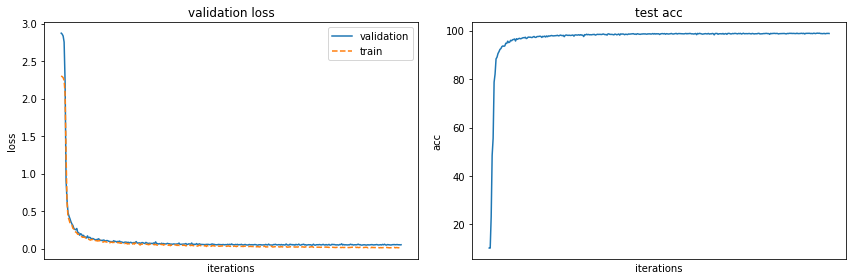

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(curve_x,v_loss_curve_y, label='validation')
axes[0].plot(curve_x,loss_curve_y, '--',label='train')
axes[0].set_title('validation loss')
axes[0].set_xlabel("iterations")
axes[0].set_ylabel("loss")
axes[0].set_xticks([])
axes[0].legend()
axes[1].plot(curve_x,acc_curve_y)
axes[1].set_title('test acc')
axes[1].set_xlabel("iterations")
axes[1].set_ylabel("acc")
axes[1].set_xticks([])
fig.tight_layout()
plt.show()

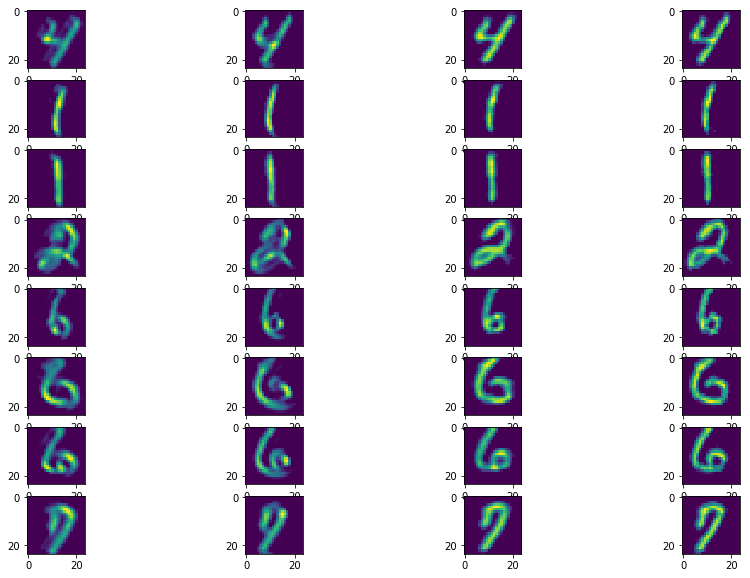

In [24]:
plt.figure(figsize=(15,10))
show_features(net.features_1(images.to(device)).detach().cpu())

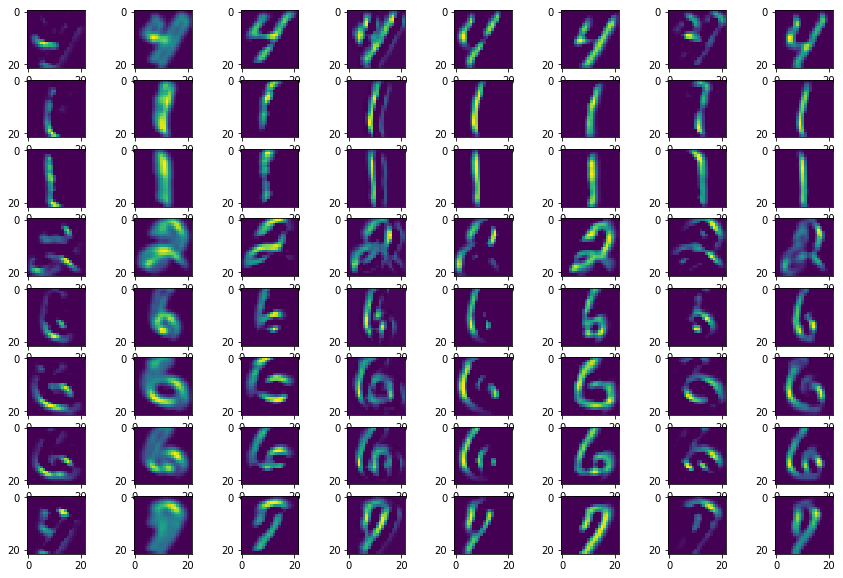

In [25]:
plt.figure(figsize=(15,10))
show_features(net.features_2(images.to(device)).detach().cpu())

gt: tensor([7, 2, 1, 0, 4, 1, 4, 9], device='cuda:0')
predict: tensor([7, 2, 1, 0, 4, 1, 4, 9], device='cuda:0')


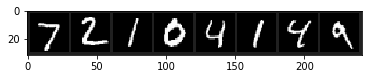

In [26]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

plt.imshow(torchvision.utils.make_grid(images.cpu())[0,:,:], cmap='gray')
print('gt:', labels)
print('predict:', predicted)

In [66]:
correct = 0
total = 0

errors_imgs=[]
errors_labels=[]
confusion_matrix = torch.zeros(10, 10)
err_confusion_matrix = torch.zeros(10, 10)
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        errors_imgs.extend(images[torch.where(predicted != labels)])
        errors_labels.extend(zip(predicted[torch.where(predicted != labels)], labels[torch.where(predicted != labels)]))
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            if t.long() != p.long():
                err_confusion_matrix[t.long(), p.long()] += 1
errors_imgs=torch.stack(errors_imgs)
errors_labels=np.array([(p.item(), t.item())for p, t in errors_labels])
print('accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
torch.save(net, 'torch_mnist_model.pt')  

accuracy of the network on the 10000 test images: 98 %


D:\Anaconda\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [67]:
print('errors: ',len(errors_labels))

errors:  126


# heatmap

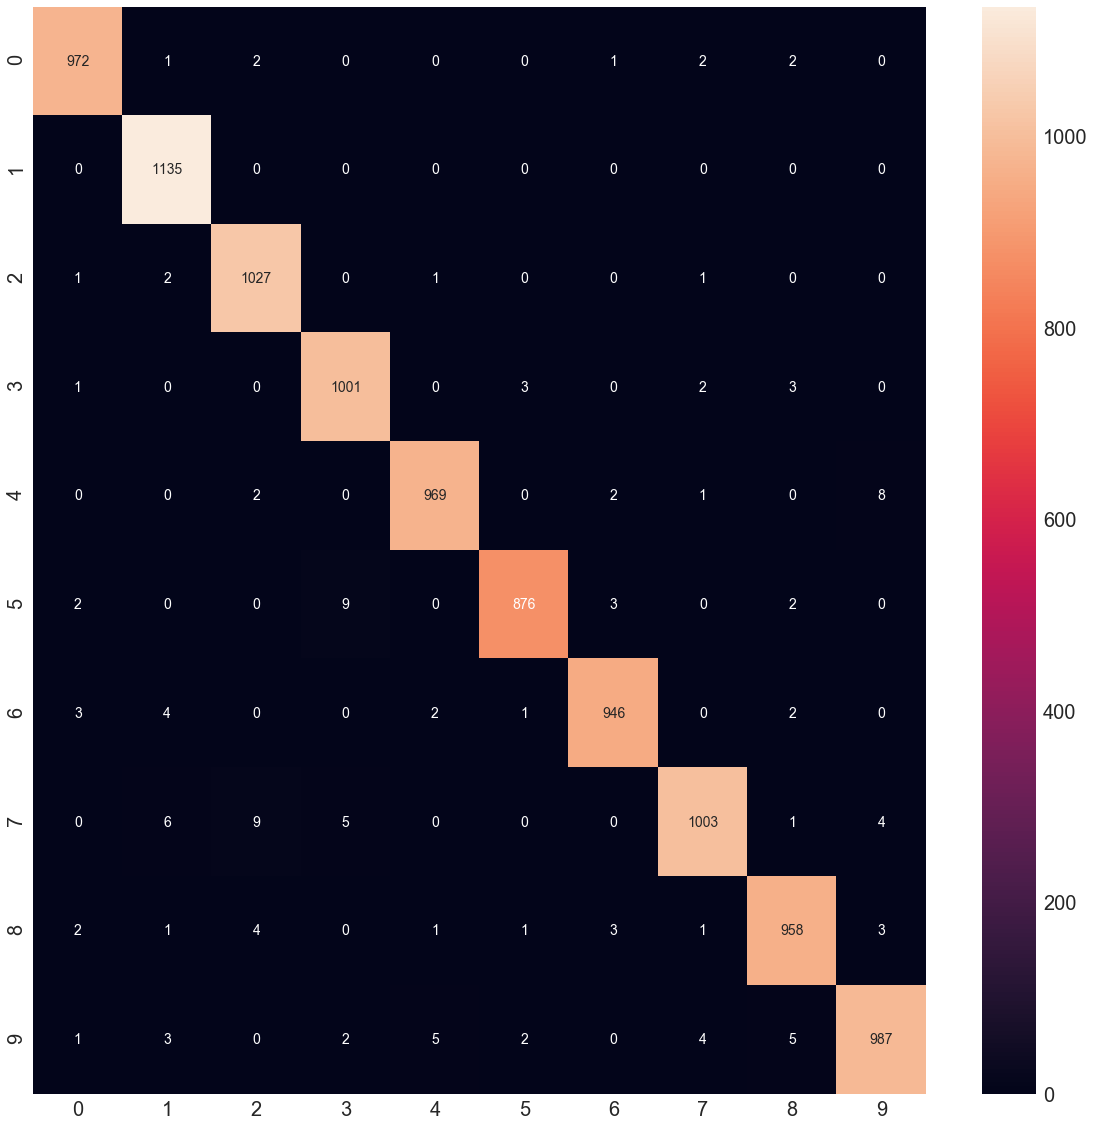

In [68]:
df_cm = pd.DataFrame(confusion_matrix.numpy(), range(10), range(10))

plt.figure(figsize = (20,20))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, fmt='g')

# errors heatmap

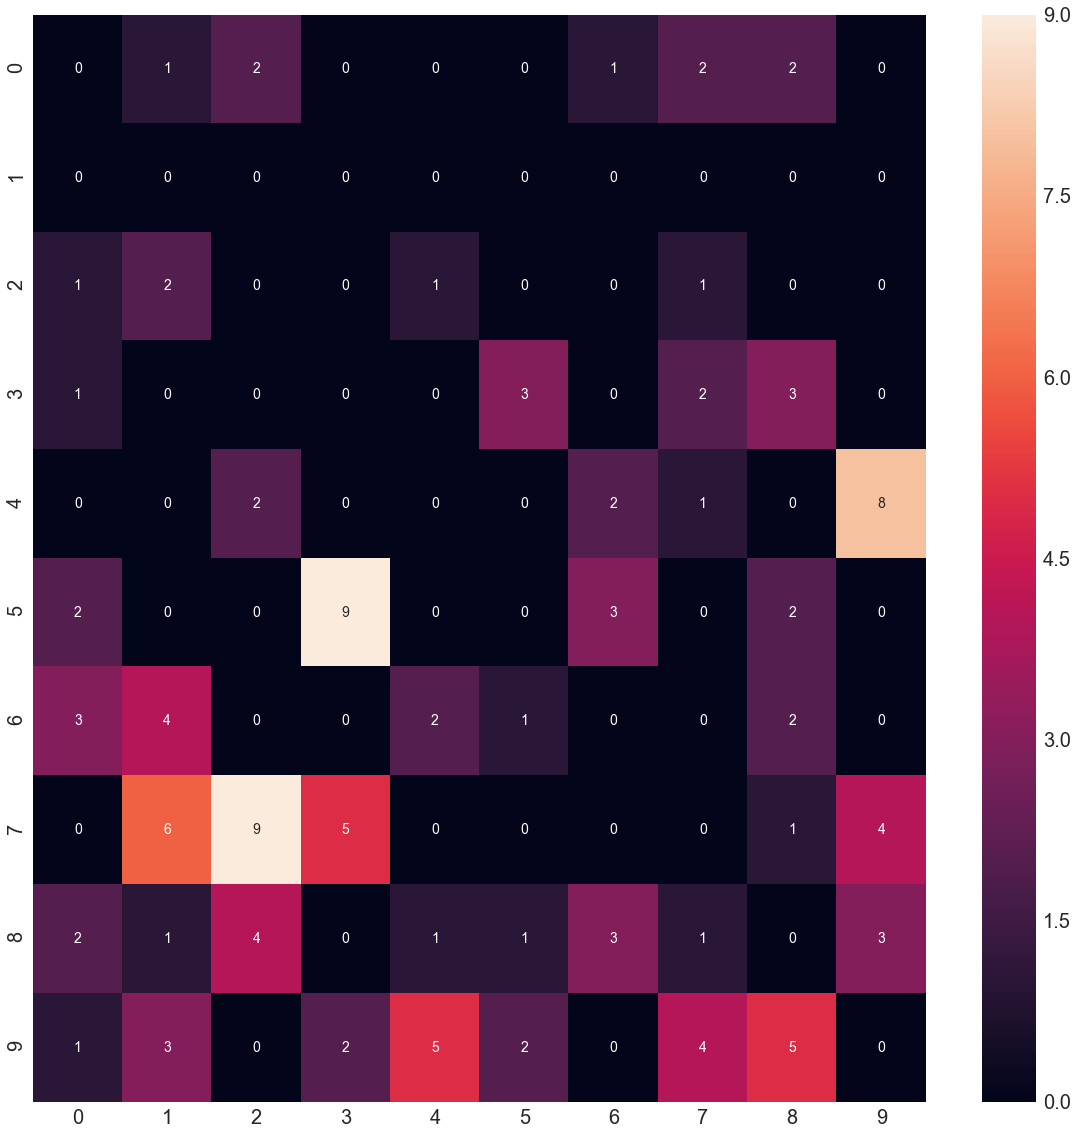

In [69]:
df_cm = pd.DataFrame(err_confusion_matrix.numpy(), range(10), range(10))

plt.figure(figsize = (20,20))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, fmt='g')

In [70]:
sn.set(font_scale=1)
sn.set_style("whitegrid", {'axes.grid' : False})

In [71]:
f=lambda i, a: ({k: len(v) for k, v in a.items()} if [a[x].append(i) for x in i] else {})

In [72]:
errors=f(errors_labels[:,1],defaultdict(list))

# errors distribution

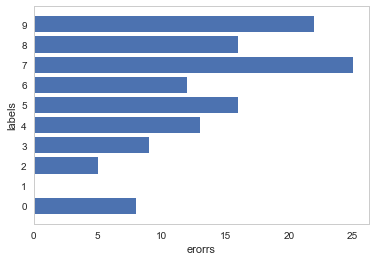

In [73]:
plt.figure(figsize=(6,4))
plt.barh(*zip(*errors.items()))
plt.yticks(range(10))
plt.xlabel('erorrs')
plt.ylabel('labels')
plt.show()

# errors features

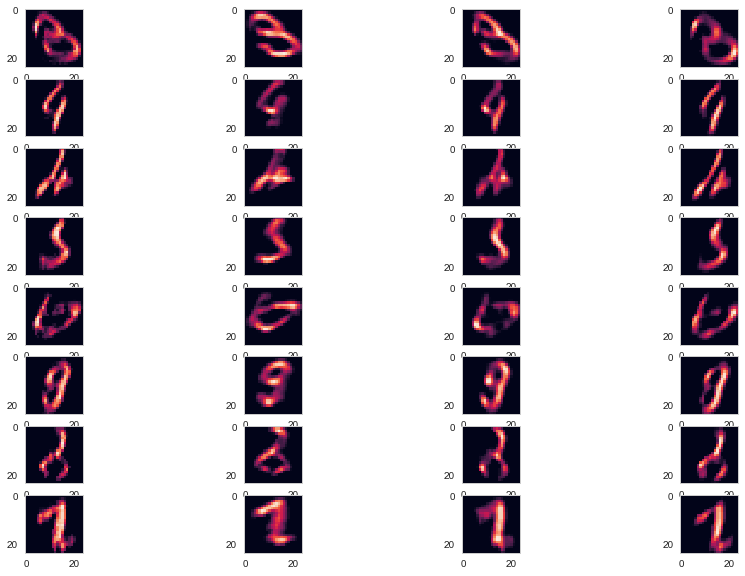

In [74]:
plt.figure(figsize=(15,10))
show_features(net.features_1(errors_imgs[:8]).detach().cpu())

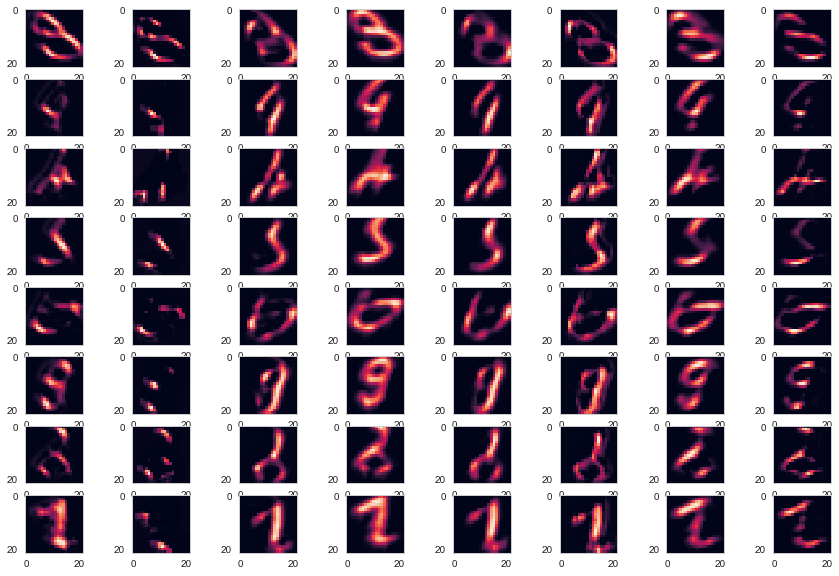

In [75]:
plt.figure(figsize=(15,10))
show_features(net.features_2(errors_imgs[:8]).detach().cpu())

# errors examples

predicted:  8 != true:  3


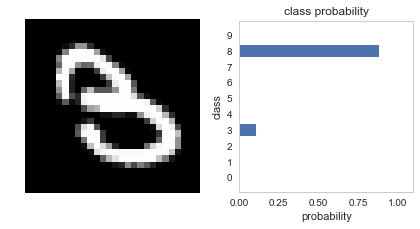

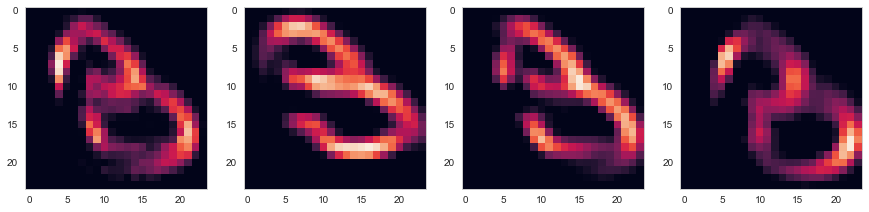

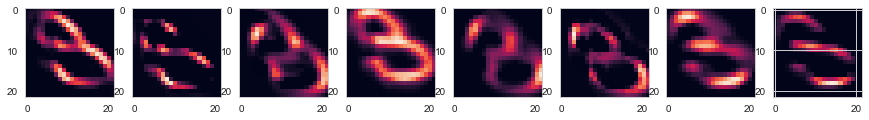

predicted:  9 != true:  4


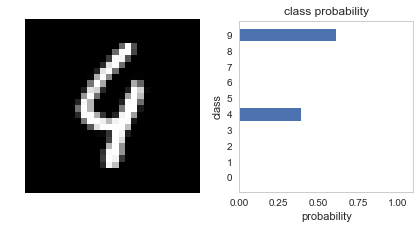

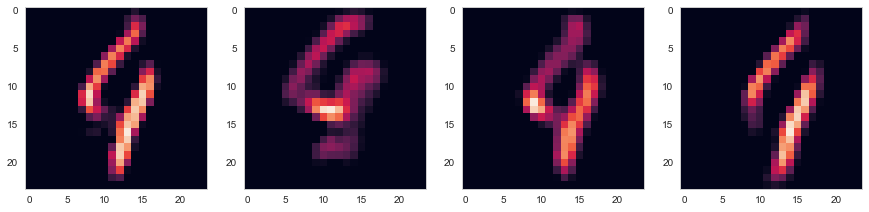

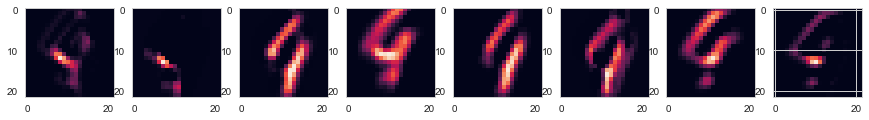

predicted:  2 != true:  4


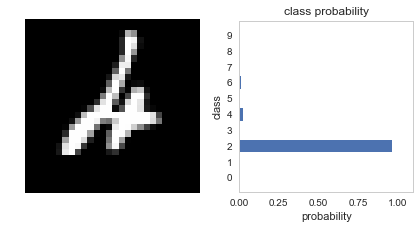

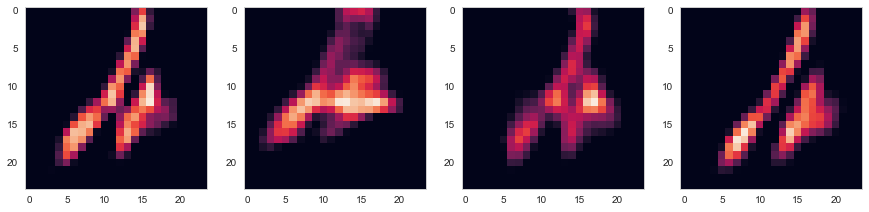

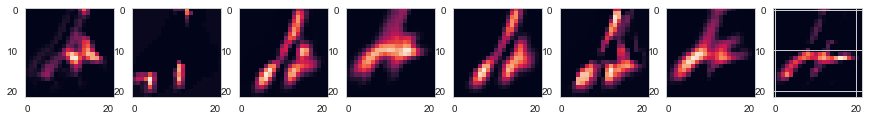

predicted:  3 != true:  5


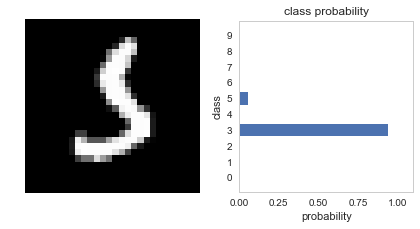

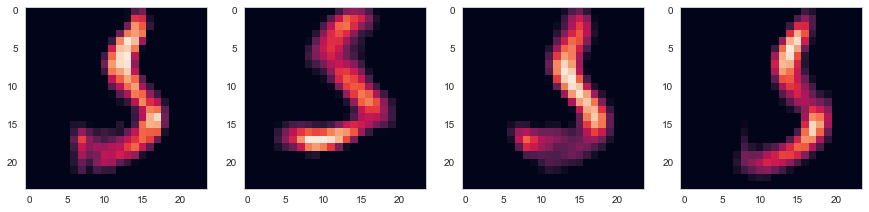

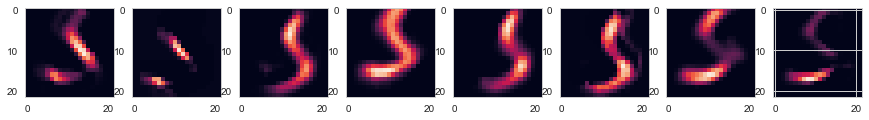

predicted:  0 != true:  6


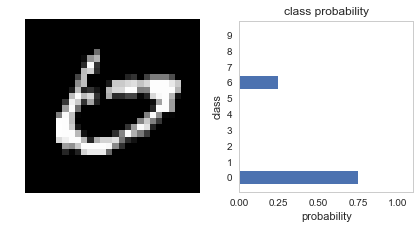

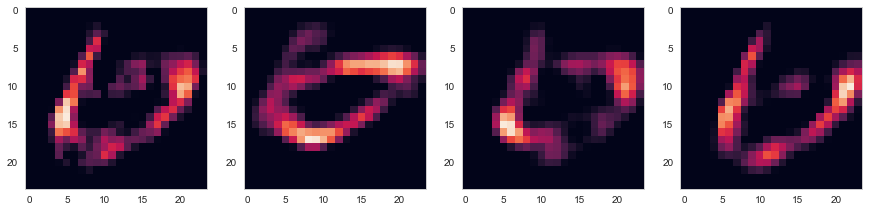

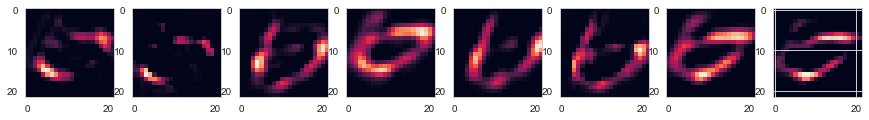

predicted:  8 != true:  9


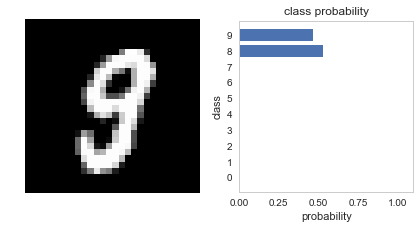

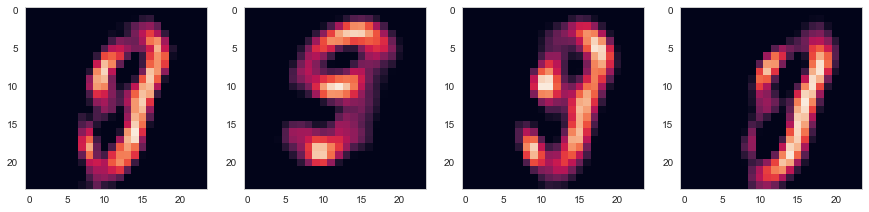

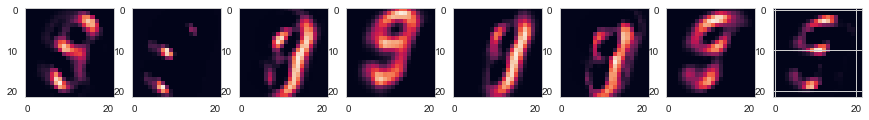

predicted:  2 != true:  8


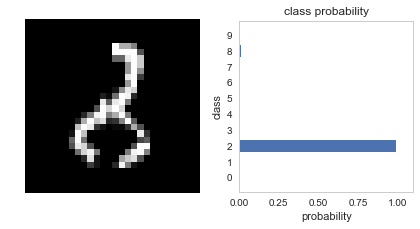

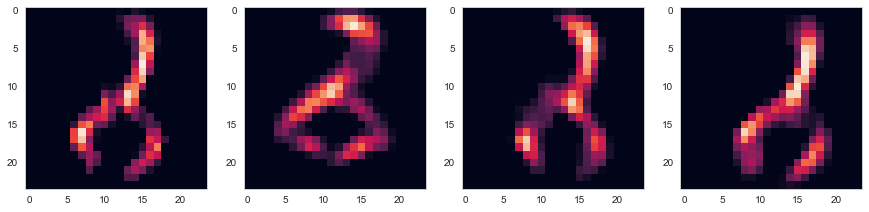

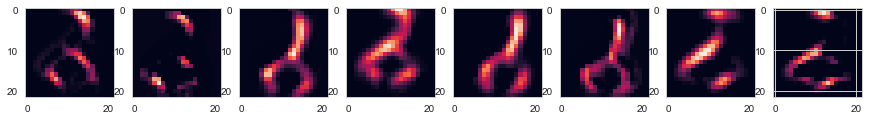

predicted:  1 != true:  2


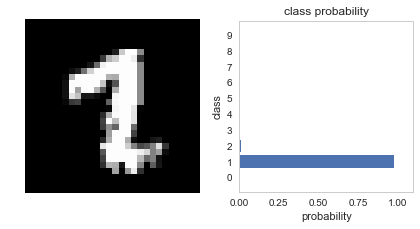

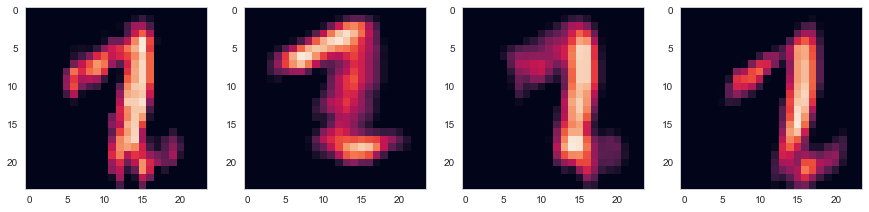

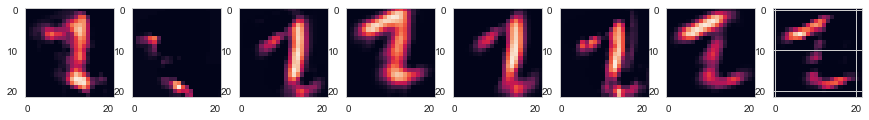

predicted:  3 != true:  5


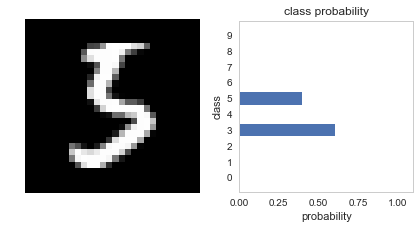

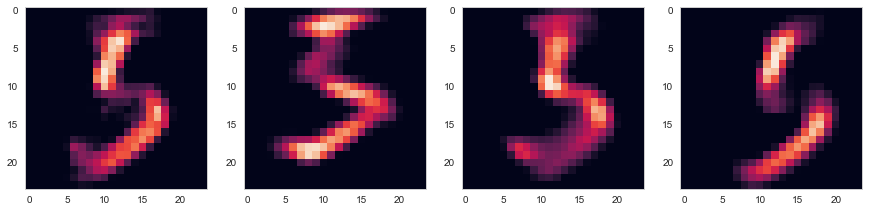

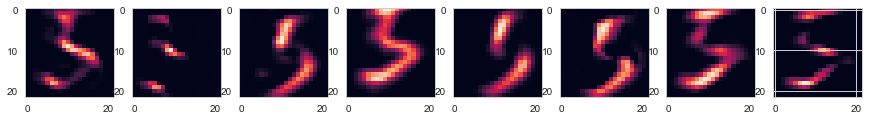

predicted:  8 != true:  5


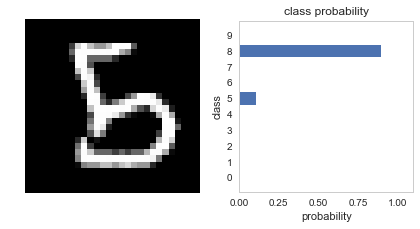

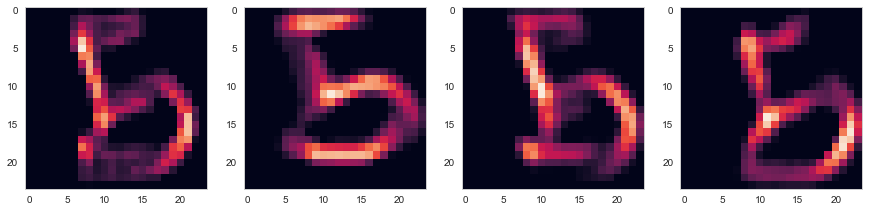

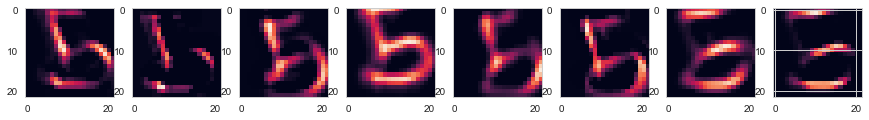

In [76]:
for img_indx in range(10):
    print('predicted: ', errors_labels[img_indx][0].item(), '!=','true: ', errors_labels[img_indx][1].item())
    ps = net.forward(errors_imgs[img_indx].unsqueeze(0))
    view_classify(errors_imgs[img_indx].cpu(), torch.softmax(ps,dim=1))

    plt.figure(figsize=(15,10))
    show_features(net.features_1(errors_imgs[img_indx:img_indx+1].to(device)).detach().cpu())

    plt.figure(figsize=(15,10))
    show_features(net.features_2(errors_imgs[img_indx:img_indx+1].to(device)).detach().cpu())

    plt.grid()
    plt.pause(0.1)

# kaggle submission

In [77]:
# net=torch.load('torch_mnist_model.pt')
# net.eval()

In [78]:
kaggle=pd.read_csv('test.csv')

In [79]:
kaggle.shape

(28000, 784)

In [80]:
kaggle=torch.from_numpy(kaggle.values)

In [81]:
kaggle=kaggle.view(28000,28,28).to(device)

In [82]:
# T = transforms.Compose([
#     transforms.Normalize((img_norm_mean,), (img_std,))
# ])
# kaggle=T(kaggle)

In [83]:
predictions=[]
with torch.no_grad():
    for i, data in enumerate(kaggle):
        images = data.to(device)
        outputs = net(images.float().unsqueeze(0).unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        predictions.append([i+1,predicted.item()])

In [84]:
predictions=pd.DataFrame(predictions)

In [85]:
predictions.columns=['ImageId','Label']

In [86]:
predictions.to_csv('submission.csv',sep=',',index=None)

![title](kaggle_mnist.png)